In [234]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

In [235]:
df = pd.read_csv('../../project/data/synthetic_data_v5.csv')

# 1. Structuring the data

In [236]:
df.tail()

,transaction_date,category,product,amount,is_event,event_name,is_holiday
94115,2025-06-30,government,tax_payment,6000.73,True,New Year English,True
94116,2025-06-30,government,govt_fee,6556.95,True,New Year English,True
94117,2025-06-30,shopping,online_shopping,1484.73,True,New Year English,True
94118,2025-06-30,insurance,insurance_payment,1138.25,True,New Year English,True
94119,2025-06-30,shopping,mobile_data_pack,6630.10,True,New Year English,True


In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94120 entries, 0 to 94119
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_date  94120 non-null  object 
 1   category          94120 non-null  object 
 2   product           94120 non-null  object 
 3   amount            94120 non-null  float64
 4   is_event          94120 non-null  bool   
 5   event_name        13574 non-null  object 
 6   is_holiday        94120 non-null  bool   
dtypes: bool(2), float64(1), object(4)
memory usage: 3.8+ MB


In [238]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

In [239]:

# Set full date range
full_date_range = pd.date_range(start=df['transaction_date'].min(),
                                end=df['transaction_date'].max())

# Get all unique categories or products
all_products = df['product'].unique()

# Create complete cartesian product of dates and categories
complete_index = pd.MultiIndex.from_product(
    [all_products, full_date_range],
    names=['product', 'transaction_date']
)

# Group & aggregate per day per category if not already
df_daily = df.groupby(['category', 'product', 'transaction_date']) \
    .agg({
            "amount": "sum",
            "is_event": "max",    # If any row that day is a festival, mark it as True
            "event_name": "first",   # Just keep the first festival name (optional)
            "is_holiday": "max"      # If any row that day is a holiday, mark it as True
        }).reset_index()
                                                        

# Reindex to include all date-category pairs
df_full = df_daily.set_index(['product', 'transaction_date']).reindex(complete_index)

# Fill missing amount with 0
df_full['amount'] = df_full['amount'].fillna(0)

# Reset index for further processing
aggregated_df = df_full.reset_index()



In [240]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19746 entries, 0 to 19745
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   product           19746 non-null  object        
 1   transaction_date  19746 non-null  datetime64[ns]
 2   category          19121 non-null  object        
 3   amount            19746 non-null  float64       
 4   is_event          19121 non-null  object        
 5   event_name        1264 non-null   object        
 6   is_holiday        19121 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 1.1+ MB


In [241]:
aggregated_df['is_event'] = aggregated_df['is_event'].astype('bool')
aggregated_df['is_holiday'] = aggregated_df['is_holiday'].astype('bool')

In [242]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19746 entries, 0 to 19745
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   product           19746 non-null  object        
 1   transaction_date  19746 non-null  datetime64[ns]
 2   category          19121 non-null  object        
 3   amount            19746 non-null  float64       
 4   is_event          19746 non-null  bool          
 5   event_name        1264 non-null   object        
 6   is_holiday        19746 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float64(1), object(3)
memory usage: 810.0+ KB


In [243]:
aggregated_df.rename(columns={'amount': "transaction_amount"}, inplace=True)

In [244]:
# Step 3: Sort the result
aggregated_df.sort_values(["transaction_date", "category", 'product'], inplace=True)

In [245]:
aggregated_df.is_event.value_counts()

is_event
False    17920
True      1826
Name: count, dtype: int64

In [246]:
df.shape

(94120, 7)

In [247]:
aggregated_df.shape

(19746, 7)

# 2. Data Profiling

In [248]:
aggregated_df.event_name.unique()

array(['New Year English', None, nan, 'Maghe Sankranti',
       "Valentine's Day", 'Shivaratri', 'Holi', 'New Year Nepali',
       "Mother's Day", 'Buddha Jayanti', 'Rakhshya Bandhan', 'Teej',
       'Indra Jatra', 'Dashain Day 1', 'Dashain Day 2', 'Dashain Day 3',
       'Dashain Day 4', 'Dashain Day 5', 'Tihar Day 1', 'Tihar Day 2',
       'Tihar Day 3', 'Tihar Day 4', 'Chhath', 'Christmas', 'Earthquake',
       'Recession Alert'], dtype=object)

# 3. Feature Engineering

In [249]:
def classify_event(name):
    if pd.isna(name):
        return "none"
    if name.lower() in ["earthquake", "recession alert"]:
        return "disaster"
    return "festival"

aggregated_df["event_type"] = aggregated_df["event_name"].apply(classify_event)


In [250]:
aggregated_df.event_type.value_counts()

event_type
none        18482
festival     1201
disaster       63
Name: count, dtype: int64

### 3.1 Accounting for pre and post event effects

In [251]:
from datetime import timedelta

# Get all event dates by product
event_dates = aggregated_df.dropna(subset=["event_name"])[["transaction_date", "category", 'product']]

# Initialize flags
aggregated_df["pre_event_window"] = False
aggregated_df["post_event_window"] = False

# Loop through events to set flags
for _, row in event_dates.iterrows():
    cat = row["category"]
    prod = row["product"]
    date = row["transaction_date"]

    mask_pre = (aggregated_df["category"] == cat) & (aggregated_df["product"] == prod) & \
               (aggregated_df["transaction_date"] >= date - timedelta(days=7)) & \
               (aggregated_df["transaction_date"] < date)
    
    mask_post =(aggregated_df["category"] == cat) & (aggregated_df["product"] == prod) & \
                (aggregated_df["transaction_date"] > date) & \
                (aggregated_df["transaction_date"] <= date + timedelta(days=7))

    aggregated_df.loc[mask_pre, "pre_event_window"] = True
    aggregated_df.loc[mask_post, "post_event_window"] = True


In [252]:
aggregated_df.head()

,product,transaction_date,category,transaction_amount,is_event,event_name,is_holiday,event_type,pre_event_window,post_event_window
5485,bank_deposit,2022-06-30,bank_transaction,68514.51,True,New Year English,True,festival,False,False
10970,bank_withdrawal,2022-06-30,bank_transaction,42504.37,True,New Year English,True,festival,False,False
13164,electricity_bill,2022-06-30,bill_payment,22606.89,True,New Year English,True,festival,False,False
6582,internet_bill,2022-06-30,bill_payment,35946.78,True,New Year English,True,festival,False,False
2194,water_bill,2022-06-30,bill_payment,41235.86,True,New Year English,True,festival,False,False


In [253]:
# aggregated_df.set_index(['transaction_date'], inplace=True)
#

In [254]:
# unique_categories = aggregated_df['product'].unique()

# for cat in unique_categories:
#     rolling_mean_data = aggregated_df[(aggregated_df['product'] == cat)]['transaction_amount'].rolling(window=20).mean()
#     aggregated_df.loc[aggregated_df['product'] == cat, 'transaction_amount'] = rolling_mean_data

<Axes: >

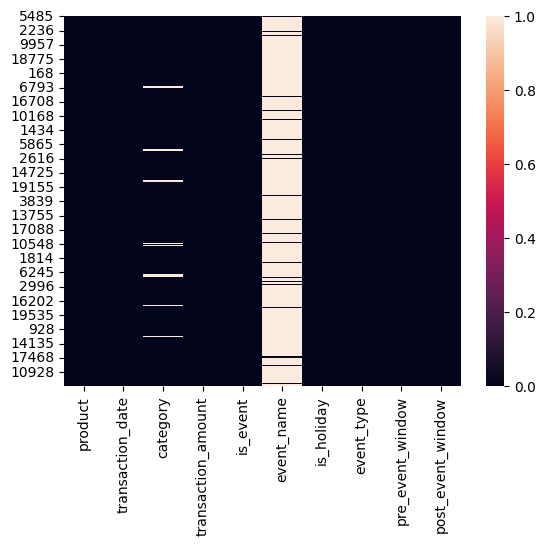

In [255]:
sns.heatmap(aggregated_df.isna())

<Axes: >

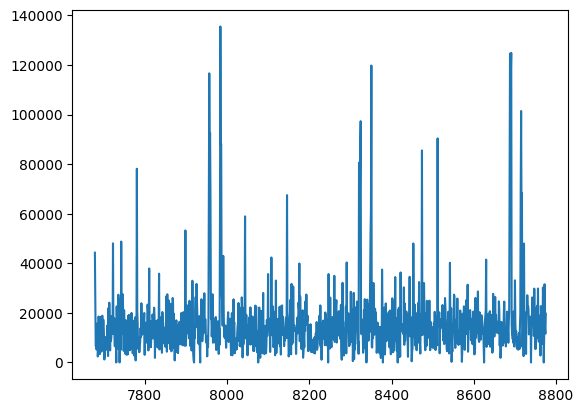

In [256]:
aggregated_df['transaction_amount'][aggregated_df['product'] == 'ncell_topup'].plot()

### 3.2 Making cyclical features for the dates

In [257]:
# Day of Week (0 to 6)
aggregated_df["day_of_week"] = aggregated_df["transaction_date"].dt.dayofweek
# Shift so that Sunday = 1, Monday = 2, ..., Saturday = 7
aggregated_df["day_of_week"] = ((aggregated_df["day_of_week"] + 1) % 7) + 1
aggregated_df["day_of_week_sin"] = np.sin(2 * np.pi * aggregated_df["day_of_week"] / 7)
aggregated_df["day_of_week_cos"] = np.cos(2 * np.pi * aggregated_df["day_of_week"] / 7)

# Month (1 to 12)
aggregated_df["month"] = aggregated_df["transaction_date"].dt.month
aggregated_df["month_sin"] = np.sin(2 * np.pi * aggregated_df["month"] / 12)
aggregated_df["month_cos"] = np.cos(2 * np.pi * aggregated_df["month"] / 12)


# Year (1 to 365)
aggregated_df["day_of_year"] = aggregated_df["transaction_date"].dt.dayofyear
aggregated_df["day_of_year_sin"] = np.sin(2 * np.pi * aggregated_df["day_of_year"] / 365)
aggregated_df["day_of_year_cos"] = np.cos(2 * np.pi * aggregated_df["day_of_year"] / 365)

In [258]:
aggregated_df.drop(columns=["day_of_week", "month", 'day_of_year'], inplace=True)

In [259]:
aggregated_df.shape

(19746, 16)

### 3.3 Removing the unwanted columns

In [260]:
aggregated_df.drop(columns=['event_name'], inplace=True)

### 3.4 Creating Lag features and rolling mean statistics

In [261]:
# Ensure the data is sorted by date
aggregated_df = aggregated_df.sort_values(["transaction_date", 'category', 'product'])

# Create lag features
for lag in [1, 7, 14]:
    aggregated_df[f"lag_{lag}"] = aggregated_df.groupby(['category', 'product'])["transaction_amount"].shift(lag)


In [262]:
# Create 7-day and 30-day rolling means
for window in [7, 14]:
    aggregated_df[f"rolling_mean_{window}"] = (
        aggregated_df.groupby(['category', 'product'])["transaction_amount"]
        .transform(lambda x: x.shift(1).rolling(window=window).mean())
    )


### 3.4 Droping unwanted rows

In [263]:
aggregated_df.dropna(inplace=True)

In [264]:
aggregated_df.shape

(18869, 20)

# 4. Performing the train-test split

In [265]:
train_list, test_list = [], []

for cat in aggregated_df['product'].unique():
    df_cat = aggregated_df[aggregated_df['product'] == cat]
    cutoff = df_cat['transaction_date'].quantile(0.8)
    
    train_list.append(df_cat[df_cat['transaction_date'] <= cutoff])
    test_list.append(df_cat[df_cat['transaction_date'] > cutoff])

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)


In [266]:
train_df.head()

,product,transaction_date,category,transaction_amount,is_event,is_holiday,event_type,pre_event_window,post_event_window,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos,lag_1,lag_7,lag_14,rolling_mean_7,rolling_mean_14
5499,bank_deposit,2022-07-14,bank_transaction,9296.13,False,False,none,False,True,-9.749279e-01,-0.222521,-0.5,-0.866025,-0.213521,-0.976938,22777.23,7994.07,68514.51,12919.087143,15870.295000
5500,bank_deposit,2022-07-15,bank_transaction,7629.27,False,True,none,False,True,-7.818315e-01,0.623490,-0.5,-0.866025,-0.230306,-0.973118,9296.13,13248.82,12943.70,13105.095714,11640.410714
5501,bank_deposit,2022-07-16,bank_transaction,15412.51,False,False,none,False,True,-2.449294e-16,1.000000,-0.5,-0.866025,-0.247022,-0.969010,7629.27,10563.20,22524.48,12302.302857,11260.808571
5502,bank_deposit,2022-07-17,bank_transaction,27404.51,False,False,none,False,True,7.818315e-01,0.623490,-0.5,-0.866025,-0.263665,-0.964614,15412.51,14452.91,10809.77,12995.061429,10752.810714
5503,bank_deposit,2022-07-18,bank_transaction,8196.08,False,False,none,False,True,9.749279e-01,-0.222521,-0.5,-0.866025,-0.280231,-0.959933,27404.51,12446.49,3632.80,14845.290000,11938.149286


### 4.1.1 Encoding the categorical features using Target Encoding and One-Hot Encoding

In [267]:
# train_df.drop(columns=['transaction_date'], inplace=True)
# test_df.drop(columns=['transaction_date'], inplace=True)

In [268]:
# Step 1: Compute mean target value per category (from training data only)
product_target_mean = train_df.groupby('product')['transaction_amount'].mean()
category_target_mean = train_df.groupby('category')['transaction_amount'].mean()

# Step 2: Map encoded values to both train and test sets
train_df['product'] = train_df['product'].map(product_target_mean)
test_df['product'] = test_df['product'].map(product_target_mean)
train_df['category'] = train_df['category'].map(category_target_mean)
test_df['category'] = test_df['category'].map(category_target_mean)

# Step 3 (optional): Fill NaNs in test set (in case unseen categories exist)
global_mean = train_df['transaction_amount'].mean()
test_df['product'].fillna(global_mean, inplace=True)


C:\Users\JARVIS\AppData\Local\Temp\ipykernel_10236\405799129.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['product'].fillna(global_mean, inplace=True)


In [269]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# 2. Create and fit encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train_df[['event_type']])

# 3. Transform both train and test
train_encoded = encoder.transform(train_df[['event_type']])
test_encoded = encoder.transform(test_df[['event_type']])

# 4. Get encoded column names
encoded_cols = encoder.get_feature_names_out(['event_type'])

# 5. Convert to DataFrame
train_encoded_df = pd.DataFrame(train_encoded, columns=encoded_cols, index=train_df.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_cols, index=test_df.index)

# 6. Merge with original DataFrames
train_df = pd.concat([train_df.drop(columns=['event_type']), train_encoded_df], axis=1)
test_df = pd.concat([test_df.drop(columns=['event_type']), test_encoded_df], axis=1)


In [270]:
X_train = train_df.dropna(subset=['transaction_amount']).drop(columns=['transaction_amount', 'transaction_date'])
X_test = test_df.dropna(subset=['transaction_amount']).drop(columns=['transaction_amount', 'transaction_date'])

y_train = train_df['transaction_amount']
y_test = test_df['transaction_amount']


In [271]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15092 entries, 5499 to 16238
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   product              15092 non-null  float64       
 1   transaction_date     15092 non-null  datetime64[ns]
 2   category             15092 non-null  float64       
 3   transaction_amount   15092 non-null  float64       
 4   is_event             15092 non-null  bool          
 5   is_holiday           15092 non-null  bool          
 6   pre_event_window     15092 non-null  bool          
 7   post_event_window    15092 non-null  bool          
 8   day_of_week_sin      15092 non-null  float64       
 9   day_of_week_cos      15092 non-null  float64       
 10  month_sin            15092 non-null  float64       
 11  month_cos            15092 non-null  float64       
 12  day_of_year_sin      15092 non-null  float64       
 13  day_of_year_cos      15092 non-nu

# 5. Training the model

In [272]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15092 entries, 5499 to 16238
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   product              15092 non-null  float64       
 1   transaction_date     15092 non-null  datetime64[ns]
 2   category             15092 non-null  float64       
 3   transaction_amount   15092 non-null  float64       
 4   is_event             15092 non-null  bool          
 5   is_holiday           15092 non-null  bool          
 6   pre_event_window     15092 non-null  bool          
 7   post_event_window    15092 non-null  bool          
 8   day_of_week_sin      15092 non-null  float64       
 9   day_of_week_cos      15092 non-null  float64       
 10  month_sin            15092 non-null  float64       
 11  month_cos            15092 non-null  float64       
 12  day_of_year_sin      15092 non-null  float64       
 13  day_of_year_cos      15092 non-nu

In [273]:
train_df.head()

,product,transaction_date,category,transaction_amount,is_event,is_holiday,pre_event_window,post_event_window,day_of_week_sin,day_of_week_cos,...,day_of_year_sin,day_of_year_cos,lag_1,lag_7,lag_14,rolling_mean_7,rolling_mean_14,event_type_disaster,event_type_festival,event_type_none
5499,14678.482859,2022-07-14,14404.985939,9296.13,False,False,False,True,-9.749279e-01,-0.222521,...,-0.213521,-0.976938,22777.23,7994.07,68514.51,12919.087143,15870.295000,0.0,0.0,1.0
5500,14678.482859,2022-07-15,14404.985939,7629.27,False,True,False,True,-7.818315e-01,0.623490,...,-0.230306,-0.973118,9296.13,13248.82,12943.70,13105.095714,11640.410714,0.0,0.0,1.0
5501,14678.482859,2022-07-16,14404.985939,15412.51,False,False,False,True,-2.449294e-16,1.000000,...,-0.247022,-0.969010,7629.27,10563.20,22524.48,12302.302857,11260.808571,0.0,0.0,1.0
5502,14678.482859,2022-07-17,14404.985939,27404.51,False,False,False,True,7.818315e-01,0.623490,...,-0.263665,-0.964614,15412.51,14452.91,10809.77,12995.061429,10752.810714,0.0,0.0,1.0
5503,14678.482859,2022-07-18,14404.985939,8196.08,False,False,False,True,9.749279e-01,-0.222521,...,-0.280231,-0.959933,27404.51,12446.49,3632.80,14845.290000,11938.149286,0.0,0.0,1.0


In [274]:
X_train.head()

,product,category,is_event,is_holiday,pre_event_window,post_event_window,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos,lag_1,lag_7,lag_14,rolling_mean_7,rolling_mean_14,event_type_disaster,event_type_festival,event_type_none
5499,14678.482859,14404.985939,False,False,False,True,-9.749279e-01,-0.222521,-0.5,-0.866025,-0.213521,-0.976938,22777.23,7994.07,68514.51,12919.087143,15870.295000,0.0,0.0,1.0
5500,14678.482859,14404.985939,False,True,False,True,-7.818315e-01,0.623490,-0.5,-0.866025,-0.230306,-0.973118,9296.13,13248.82,12943.70,13105.095714,11640.410714,0.0,0.0,1.0
5501,14678.482859,14404.985939,False,False,False,True,-2.449294e-16,1.000000,-0.5,-0.866025,-0.247022,-0.969010,7629.27,10563.20,22524.48,12302.302857,11260.808571,0.0,0.0,1.0
5502,14678.482859,14404.985939,False,False,False,True,7.818315e-01,0.623490,-0.5,-0.866025,-0.263665,-0.964614,15412.51,14452.91,10809.77,12995.061429,10752.810714,0.0,0.0,1.0
5503,14678.482859,14404.985939,False,False,False,True,9.749279e-01,-0.222521,-0.5,-0.866025,-0.280231,-0.959933,27404.51,12446.49,3632.80,14845.290000,11938.149286,0.0,0.0,1.0


In [275]:
from xgboost import XGBRegressor

# Train
model_xgb = XGBRegressor(n_estimators=100)
model_xgb.fit(X_train, y_train)

# Predict
y_pred = model_xgb.predict(X_test)

# 6. Evaluation

In [276]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15092 entries, 5499 to 16238
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   product              15092 non-null  float64       
 1   transaction_date     15092 non-null  datetime64[ns]
 2   category             15092 non-null  float64       
 3   transaction_amount   15092 non-null  float64       
 4   is_event             15092 non-null  bool          
 5   is_holiday           15092 non-null  bool          
 6   pre_event_window     15092 non-null  bool          
 7   post_event_window    15092 non-null  bool          
 8   day_of_week_sin      15092 non-null  float64       
 9   day_of_week_cos      15092 non-null  float64       
 10  month_sin            15092 non-null  float64       
 11  month_cos            15092 non-null  float64       
 12  day_of_year_sin      15092 non-null  float64       
 13  day_of_year_cos      15092 non-nu

In [277]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

mae_xgb = mean_absolute_error(y_test, y_pred)
print("MAE:", mae_xgb)

r2_xgb = r2_score(y_test, y_pred)
print("R-squared:", r2_xgb)

mape_xgb = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape_xgb)

MAE: 6610.1960094856095
R-squared: 0.6788472230540465
MAPE: 1.1060197673439243


# 7. Forecasting

In [278]:
_transaction_df = None  # cache in memory


def load_transaction_data(refresh=False) -> pd.DataFrame:
    global _transaction_df

    if _transaction_df is None or refresh:
        df = pd.read_csv('../../project/data/synthetic_data_v5.csv')  # or query DB
        df['transaction_date'] = pd.to_datetime(df['transaction_date'], dayfirst=True)
        df['category'] = df['category'].astype(str)
        df['product'] = df['product'].astype(str)
        _transaction_df = df

    return _transaction_df.copy()


def get_past_days_data_product(category_name, product_name, past_days=30):
    today = datetime.today()
    start_date = today - timedelta(days=past_days + 1)
    end_date = today - timedelta(days=1)
    df = load_transaction_data()
    df = df[(df['category'] == category_name) & (df['product'] == product_name)]
    df = df[df['transaction_date'].between(start_date, end_date)]

    aggregated_df = df.groupby(["transaction_date"]).agg(
        transaction_count=("amount", "count"),
        transaction_amount=("amount", "sum")
    ).reset_index()

    # Reindex to include all date-category pairs
    aggregated_df = aggregated_df.set_index('transaction_date').asfreq('D', fill_value=0)

    # Reset index for further processing
    aggregated_df = aggregated_df.reset_index()

    return aggregated_df




In [279]:
X_train.columns

Index(['product', 'category', 'is_event', 'is_holiday', 'pre_event_window',
       'post_event_window', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'lag_1', 'lag_7',
       'lag_14', 'rolling_mean_7', 'rolling_mean_14', 'event_type_disaster',
       'event_type_festival', 'event_type_none'],
      dtype='object')

In [280]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import requests

features = [
       'product', 'category', 'is_event', 'is_holiday', 'pre_event_window',
       'post_event_window', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'lag_1', 'lag_7',
       'lag_14', 'rolling_mean_7', 'rolling_mean_14', 'event_type_disaster',
       'event_type_festival', 'event_type_none'
       ]

def forecast_next_7_days_product(category_name, product_name, model, aggregated_df, category_target_mean, product_target_mean, global_mean, target_col='transaction_amount'):
    # Step 1: Filter past data for this category
    aggregated_df.sort_values('transaction_date', inplace=True)
    aggregated_df.reset_index(drop=True, inplace=True)

    # Step 2: Prepare future dates
    last_date = aggregated_df['transaction_date'].max() 
    future_dates = pd.to_datetime([last_date + timedelta(days=i+1) for i in range(7)])

    forecasts = []
    
    for forecast_date in future_dates:
        row = {}
        row['transaction_date'] = forecast_date

        # === Static Features ===
        row['category'] = category_target_mean.get(category_name, global_mean)
        row['product'] = product_target_mean.get(product_name, global_mean)

        data = requests.get(f'http://127.0.0.1:8000/api/calender/info/{forecast_date}').json()
        row['is_event'] = data.get('is_event', False)
        row['is_holiday'] = data.get('is_holiday', False)
        row['pre_event_window'] = data.get('pre_event_window', False)
        row['post_event_window'] = data.get('post_event_window', False)

        # === Cyclical Features ===
        dow = forecast_date.weekday()  # Monday=0
        row["day_of_week"] = row["transaction_date"].dayofweek
        row["day_of_week"] = ((row["day_of_week"] + 1) % 7) + 1
        row['day_of_week_sin'] = np.sin(2 * np.pi * dow / 7)
        row['day_of_week_cos'] = np.cos(2 * np.pi * dow / 7)

        month = forecast_date.month
        row['month_sin'] = np.sin(2 * np.pi * month / 12)
        row['month_cos'] = np.cos(2 * np.pi * month / 12)

        day_of_year = forecast_date.dayofyear
        row['day_of_year_sin'] = np.sin(2 * np.pi * day_of_year / 365)
        row['day_of_year_cos'] = np.cos(2 * np.pi * day_of_year / 365)

        # === One-hot Event Type ===
        row['event_type_festival'] = data.get('event_type', 'none') == 'festival'
        row['event_type_disaster'] = data.get('event_type', 'none') == 'disaster'
        row['event_type_none'] = data.get('event_type', 'none') == 'none'

        # === Lag and Rolling ===
        # Make sure to handle missing lag values (e.g. beginning of series)
        try:
            row['lag_1'] = aggregated_df.iloc[-1][target_col]
            row['lag_7'] = aggregated_df.iloc[-7][target_col] if len(aggregated_df) >= 7 else row['lag_1']
            row['lag_14'] = aggregated_df.iloc[-14][target_col] if len(aggregated_df) >= 14 else row['lag_7']
        except IndexError:
            row['lag_1'] = row['lag_7'] = row['lag_14'] = aggregated_df[target_col].mean()

        row['rolling_mean_7'] = aggregated_df[target_col].rolling(window=7).mean().iloc[-1] if len(df_cat) >= 7 else df_cat['transaction_amount'].mean()
        row['rolling_mean_14'] = aggregated_df[target_col].rolling(window=14).mean().iloc[-1] if len(df_cat) >= 14 else df_cat['transaction_amount'].mean()

        # Convert to DataFrame and predict
        X = pd.DataFrame([row])
        prediction = model.predict(X[features])[0]
        row[target_col] = prediction

        # Append to results
        forecasts.append(row)

        # Append to aggregated_df to maintain rolling window
        aggregated_df = pd.concat([aggregated_df, pd.DataFrame({
            'transaction_date': [forecast_date],
            target_col: [prediction]
        })], ignore_index=True)

    return pd.DataFrame(forecasts)


In [281]:
df_30 = get_past_days_data_product('topup','ntc_topup', past_days=30)

forecast_df = forecast_next_7_days_product(
    category_name='topup',
    product_name='ntc_topup',
    model=model_xgb,
    aggregated_df=df_30,
    category_target_mean=category_target_mean,
    product_target_mean=product_target_mean,
    global_mean=global_mean
)
print(forecast_df[['transaction_date', 'transaction_amount']])


  transaction_date  transaction_amount
0       2025-07-01        11018.980469
1       2025-07-02        16071.501953
2       2025-07-03        12598.985352
3       2025-07-04        12456.318359
4       2025-07-05        14042.414062
5       2025-07-06        10978.396484
6       2025-07-07        13859.316406


C:\Users\JARVIS\AppData\Local\Temp\ipykernel_10236\777762402.py:9: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['transaction_date'] = pd.to_datetime(df['transaction_date'], dayfirst=True)


# 8. Saving the model

In [282]:
import pickle

with open('./models/xgb_model_product_amount.pkl', 'wb') as f:
    data = {
        'model': model_xgb,
        'category_target_mean': category_target_mean,
        'product_target_mean': product_target_mean,
        'global_mean': global_mean,
    }
    pickle.dump(data, f)